In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!cp -r /content/drive/MyDrive/ECG data

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from itertools import product
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
LABEL_COL = 187
DATASET = "ptbdb"
BATCH_SIZE = 32

In [ ]:
scaler = StandardScaler()

In [ ]:
if DATASET == "mitbih":
    mit_bih_train = pd.read_csv(os.path.join("data","ECG","mitbih_train.csv"),header=None)
    target_train = mit_bih_train[LABEL_COL].copy().values
    mit_bih_train.drop(LABEL_COL,axis=1,inplace=True)

    mit_bih_test = pd.read_csv(os.path.join("data","ECG","mitbih_test.csv"),header=None)
    target_test = mit_bih_test[LABEL_COL].copy().values
    mit_bih_test.drop(LABEL_COL,axis=1,inplace=True)

    train_features = mit_bih_train.values
    test_features = mit_bih_test.values

elif DATASET == "ptbdb":

    abnormal = pd.read_csv(os.path.join("data","ECG","ptbdb_abnormal.csv"),header=None)
    normal = pd.read_csv(os.path.join("data","ECG","ptbdb_normal.csv"),header=None)

    train_abn, test_abn = train_test_split(abnormal, test_size=0.2, random_state=42)
    train_nor, test_nor = train_test_split(normal, test_size=0.2, random_state=42)

    ptbdb_train = pd.concat([train_abn, train_nor]).sample(frac=1, random_state=42).reset_index(drop=True)
    ptbdb_test = pd.concat([test_abn, test_nor]).sample(frac=1, random_state=42).reset_index(drop=True)

    target_train = ptbdb_train[LABEL_COL].copy()
    ptbdb_train.drop(LABEL_COL,axis=1,inplace=True)

    target_test = ptbdb_test[LABEL_COL].copy()
    ptbdb_test.drop(LABEL_COL,axis=1,inplace=True)

    train_features = ptbdb_train.values
    test_features = ptbdb_test.values

scaler = scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


In [ ]:
X_train = torch.tensor(train_features,dtype=torch.float32)
y_train = torch.tensor(target_train,dtype=torch.int64)
X_test = torch.tensor(test_features,dtype=torch.float32)
y_test = torch.tensor(target_test,dtype=torch.int64)

In [ ]:
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
class MLPNet(nn.Module):

    def __init__(self, in_dim = 187, n_units=[128,32], num_classes=5, dropout=0.0, **kwargs):
        super(MLPNet, self).__init__(**kwargs)

        self.n_units = [in_dim] + n_units + [num_classes]

        self.dropout = nn.Dropout(dropout)
        self.linear_layers = nn.ModuleList([
            nn.Linear(self.n_units[idx], self.n_units[idx+1]) for idx in range(len(self.n_units)-1)
        ])

    def forward(self, x):

        for layer in self.linear_layers[:-1]:
            x = layer(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.linear_layers[-1](x)

        return x
    
class ConvNet(nn.Module):

    def __init__(self, in_channels = 1, n_units = [32, 64, 128], num_classes=5, dropout=0.0, **kwargs):
        super(ConvNet, self).__init__(**kwargs)

        self.n_units = [in_channels] + n_units

        self.convs = nn.ModuleList([
            nn.Conv1d(self.n_units[idx], self.n_units[idx+1], kernel_size=3, padding="same") for idx in range(len(self.n_units)-1)
        ])

        self.dropout = nn.Dropout(dropout)
        self.cls_head = MLPNet(self.n_units[-1], n_units=[64,16], num_classes=num_classes)

    def forward(self, x):

        x = x.unsqueeze(-1)
        x = x.transpose(1,2)

        for layer in self.convs:
            x = F.max_pool1d(F.relu(layer(x)), kernel_size=2)
            x = self.dropout(x)
        
        feat = x.mean(2)

        return self.cls_head(feat)
    

class LSTMNet(nn.Module):

    def __init__(self, in_channels = 1, hidden_size=128, dropout=0.2, bidirectional=True, num_layers=1, num_classes=5, **kwargs):
        super(LSTMNet, self).__init__(**kwargs)

        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional,
            num_layers=num_layers
        )

        self.hidden_size = hidden_size


        self.cls_head = MLPNet(hidden_size,[64,16],num_classes)

    def forward(self, x):

        x = x.unsqueeze(-1)
        batch_size, seq_len, _ = x.shape
        # feat = self.lstm(x)[0].view(batch_size,seq_len,-1,self.hidden_size)[:,-1,:,:].mean(1)
        feat = self.lstm(x)[0].view(batch_size,seq_len,-1,self.hidden_size).mean(1).mean(1)

        return self.cls_head(feat)
        

In [ ]:
in_dim = train_features.shape[-1]
num_classes = len(np.unique(target_train))

In [ ]:
MODEL = "lstm" # ["mlp", "conv", "lstm"]
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PARAM_VALUES = None
MODEL_PARAM_NAMES = None

In [ ]:
if MODEL == "mlp":

    n_units = [[128, 32], [128, 64], [64, 16], [128, 64, 16]]
    dropout = [0.0, 0.4]
    MODEL_PARAM_VALUES = [n_units, dropout]
    MODEL_PARAM_NAMES = ["n_units", "dropout"]
    
elif MODEL == "conv":

    n_units = [[32, 64, 128], [32, 64], [32, 64, 128, 256]]
    dropout = [0.0, 0.4]
    MODEL_PARAM_VALUES = [n_units, dropout]
    MODEL_PARAM_NAMES = ["n_units", "dropout"]

elif MODEL == "lstm":

    hidden_size = [64,128]
    bidirectional = [False,True]
    num_layers = [1, 2]
    dropout = [0.0,0.3]
    MODEL_PARAM_VALUES = [hidden_size, bidirectional, num_layers, dropout]
    MODEL_PARAM_NAMES = ["hidden_size", "bidirectional", "num_layers", "dropout"]

In [ ]:
def train_epoch(train_loader, epoch, train_losses):
    model.train()
    step_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        step_losses.append(loss.item())
    
    train_losses.append(np.mean(step_losses))
    print(f"Epoch {epoch}:{np.mean(step_losses):.3f}")

def eval_epoch(test_loader, test_losses):
    model.eval()
    step_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)
            step_losses.append(loss.item())
    test_losses.append(np.mean(step_losses))


In [ ]:
def metrics(test_loader,config):
    class_totals = pd.Series(target_test).value_counts()
    total = test_features.shape[0]
    correct = 0
    per_class = [{k:0 for k in ["tp","fp","fn"]} for _ in range(len(class_totals))]

    res = {"Configuration": [str(config)]}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            preds = output.argmax(1)
            correct += sum(preds == target).item()
            for class_id in range(len(class_totals)):
                per_class[class_id]["tp"] += sum(torch.logical_and(preds == class_id, target == class_id)).item()
                per_class[class_id]["fp"] += sum(torch.logical_and(preds == class_id, target != class_id)).item()
                per_class[class_id]["fn"] += sum(torch.logical_and(preds != class_id, target == class_id)).item()

    res.update({"Accuracy": correct/total})
    for class_id in range(len(class_totals)):

        a = per_class[class_id]["tp"]+per_class[class_id]["fp"]
        b = per_class[class_id]["tp"]+per_class[class_id]["fn"]

        prec = 0.0
        if a > 0:
            prec = per_class[class_id]["tp"]/a

        recall = 0.0
        if b > 0:
            recall = per_class[class_id]["tp"]/b

        f1 = 0.0
        if (prec + recall) > 0.0:
            f1 = (2 * prec * recall)/(prec + recall)
        
        res.update({f"{class_id}_prec": [prec], f"{class_id}_recall": [recall], f"{class_id}_f1": [f1]})
    return res

In [ ]:
header = {"Configuration":[],"Accuracy":[]}
header.update({f"{idx}_{metric}":[] for idx,metric in product(list(range(num_classes)), ["prec","recall","f1"])})

In [ ]:
df = pd.DataFrame.from_dict(header)

In [ ]:
losses_series = []
max_f1 = 0.0
best_state = None
best_config = None

for configuration in product(*MODEL_PARAM_VALUES):
    config = {k:v for k, v in zip(MODEL_PARAM_NAMES, configuration)}
    if MODEL == "mlp":
        model = MLPNet(in_dim=in_dim,num_classes=num_classes, **config)
    elif MODEL == "conv":
        model = ConvNet(in_channels=1,num_classes=num_classes, **config)
    elif MODEL == "lstm":
        model = LSTMNet(in_channels=1,num_classes=num_classes, **config)

    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    # optimizer= optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=1e-4)
    # scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=5)
    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)

    train_losses = []
    test_losses = []
    print(config)
    for epoch in range(EPOCHS):
        train_epoch(train_loader, epoch, train_losses)
        eval_epoch(test_loader, test_losses)
        # scheduler.step()

    losses_series.append((train_losses, test_losses))
    res = metrics(test_loader, config)

    f1s = [res[k][0] for k in res if "_f1" in k]
    average_f1 = sum(f1s)/num_classes

    if average_f1 > max_f1:
        max_f1 = average_f1
        best_state = model.state_dict()
        best_config = config


    df = pd.concat([df, pd.DataFrame.from_dict(res)], ignore_index=True)

{'hidden_size': 64, 'bidirectional': False, 'num_layers': 1, 'dropout': 0.0}
Epoch 0:0.587
Epoch 1:0.550
Epoch 2:0.538
Epoch 3:0.528
Epoch 4:0.542
Epoch 5:0.550
Epoch 6:0.539
Epoch 7:0.531
Epoch 8:0.543
Epoch 9:0.561
Epoch 10:0.547
Epoch 11:0.591
Epoch 12:0.588
Epoch 13:0.583
Epoch 14:0.575
Epoch 15:0.563
Epoch 16:0.581
Epoch 17:0.577
Epoch 18:0.557
Epoch 19:0.538
{'hidden_size': 64, 'bidirectional': False, 'num_layers': 1, 'dropout': 0.3}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:0.602
Epoch 1:0.556
Epoch 2:0.558
Epoch 3:0.578
Epoch 4:0.587
Epoch 5:0.580
Epoch 6:0.559
Epoch 7:0.548
Epoch 8:0.545
Epoch 9:0.537
Epoch 10:0.541
Epoch 11:0.554
Epoch 12:0.556
Epoch 13:0.526
Epoch 14:0.548
Epoch 15:0.563
Epoch 16:0.559
Epoch 17:0.550
Epoch 18:0.550
Epoch 19:0.575
{'hidden_size': 64, 'bidirectional': False, 'num_layers': 2, 'dropout': 0.0}
Epoch 0:0.589
Epoch 1:0.556
Epoch 2:0.548
Epoch 3:0.580
Epoch 4:0.586
Epoch 5:0.579
Epoch 6:0.572
Epoch 7:0.556
Epoch 8:0.500
Epoch 9:0.504
Epoch 10:0.481
Epoch 11:0.451
Epoch 12:0.478
Epoch 13:0.482
Epoch 14:0.432
Epoch 15:0.438
Epoch 16:0.406
Epoch 17:0.391
Epoch 18:0.363
Epoch 19:0.333
{'hidden_size': 64, 'bidirectional': False, 'num_layers': 2, 'dropout': 0.3}
Epoch 0:0.585
Epoch 1:0.569
Epoch 2:0.555
Epoch 3:0.559
Epoch 4:0.513
Epoch 5:0.426
Epoch 6:0.376
Epoch 7:0.354
Epoch 8:0.317
Epoch 9:0.301
Epoch 10:0.274
Epoch 11:0.248
Epoch 12:0.223
Epoch 13:0.199
Epoch 14:0.190
Epoch 15:0.180
Epoch 16:0.164
Epoch 17:0.149
Epoch 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:0.601
Epoch 1:0.580
Epoch 2:0.577
Epoch 3:0.567
Epoch 4:0.536
Epoch 5:0.507
Epoch 6:0.511
Epoch 7:0.506
Epoch 8:0.548
Epoch 9:0.524
Epoch 10:0.493
Epoch 11:0.501
Epoch 12:0.490
Epoch 13:0.464
Epoch 14:0.436
Epoch 15:0.429
Epoch 16:0.409
Epoch 17:0.403
Epoch 18:0.400
Epoch 19:0.399
{'hidden_size': 64, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.0}
Epoch 0:0.593
Epoch 1:0.553
Epoch 2:0.547
Epoch 3:0.541
Epoch 4:0.557
Epoch 5:0.522
Epoch 6:0.494
Epoch 7:0.466
Epoch 8:0.454
Epoch 9:0.426
Epoch 10:0.394
Epoch 11:0.368
Epoch 12:0.306
Epoch 13:0.273
Epoch 14:0.249
Epoch 15:0.227
Epoch 16:0.220
Epoch 17:0.198
Epoch 18:0.188
Epoch 19:0.186
{'hidden_size': 64, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.3}
Epoch 0:0.599
Epoch 1:0.573
Epoch 2:0.536
Epoch 3:0.557
Epoch 4:0.571
Epoch 5:0.556
Epoch 6:0.544
Epoch 7:0.538
Epoch 8:0.516
Epoch 9:0.485
Epoch 10:0.482
Epoch 11:0.469
Epoch 12:0.484
Epoch 13:0.467
Epoch 14:0.447
Epoch 15:0.422
Epoch 16:0.402
Epoch 17:0.410
Epoch 18

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:0.594
Epoch 1:0.574
Epoch 2:0.591
Epoch 3:0.583
Epoch 4:0.591
Epoch 5:0.584
Epoch 6:0.573
Epoch 7:0.591
Epoch 8:0.588
Epoch 9:0.590
Epoch 10:0.572
Epoch 11:0.545
Epoch 12:0.561
Epoch 13:0.585
Epoch 14:0.582
Epoch 15:0.567
Epoch 16:0.552
Epoch 17:0.542
Epoch 18:0.572
Epoch 19:0.582
{'hidden_size': 128, 'bidirectional': False, 'num_layers': 2, 'dropout': 0.0}
Epoch 0:0.601
Epoch 1:0.567
Epoch 2:0.556
Epoch 3:0.505
Epoch 4:0.519
Epoch 5:0.532
Epoch 6:0.534
Epoch 7:0.491
Epoch 8:0.475
Epoch 9:0.458
Epoch 10:0.469
Epoch 11:0.496
Epoch 12:0.501
Epoch 13:0.515
Epoch 14:0.494
Epoch 15:0.486
Epoch 16:0.484
Epoch 17:0.479
Epoch 18:0.468
Epoch 19:0.465
{'hidden_size': 128, 'bidirectional': False, 'num_layers': 2, 'dropout': 0.3}
Epoch 0:0.586
Epoch 1:0.567
Epoch 2:0.562
Epoch 3:0.582
Epoch 4:0.582
Epoch 5:0.584
Epoch 6:0.564
Epoch 7:0.590
Epoch 8:0.557
Epoch 9:0.515
Epoch 10:0.496
Epoch 11:0.477
Epoch 12:0.470
Epoch 13:0.487
Epoch 14:0.475
Epoch 15:0.462
Epoch 16:0.458
Epoch 17:0.452
Epoc

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:0.586
Epoch 1:0.564
Epoch 2:0.502
Epoch 3:0.505
Epoch 4:0.487
Epoch 5:0.475
Epoch 6:0.434
Epoch 7:0.651
Epoch 8:0.552
Epoch 9:0.532
Epoch 10:0.508
Epoch 11:0.424
Epoch 12:0.373
Epoch 13:0.331
Epoch 14:0.321
Epoch 15:0.294
Epoch 16:0.274
Epoch 17:0.248
Epoch 18:0.238
Epoch 19:0.224
{'hidden_size': 128, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.0}
Epoch 0:0.583
Epoch 1:0.558
Epoch 2:0.560
Epoch 3:0.568
Epoch 4:0.578
Epoch 5:0.571
Epoch 6:0.564
Epoch 7:0.567
Epoch 8:0.559
Epoch 9:0.548
Epoch 10:0.547
Epoch 11:0.497
Epoch 12:0.464
Epoch 13:0.485
Epoch 14:0.514
Epoch 15:0.478
Epoch 16:0.440
Epoch 17:0.388
Epoch 18:0.349
Epoch 19:0.339
{'hidden_size': 128, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.3}
Epoch 0:0.585
Epoch 1:0.545
Epoch 2:0.498
Epoch 3:0.389
Epoch 4:0.320
Epoch 5:0.309
Epoch 6:0.293
Epoch 7:0.237
Epoch 8:0.203
Epoch 9:0.201
Epoch 10:0.205
Epoch 11:0.169
Epoch 12:0.147
Epoch 13:0.144
Epoch 14:0.172
Epoch 15:0.196
Epoch 16:0.150
Epoch 17:0.125
Epoch 

In [ ]:
best_config

{'hidden_size': 128, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.3}

In [ ]:
best_model = None
if MODEL == "mlp":
    best_model = MLPNet(in_dim=in_dim,num_classes=num_classes, **best_config)
elif MODEL == "conv":
    best_model = ConvNet(in_channels=1,num_classes=num_classes, **best_config)
elif MODEL == "lstm":
    best_model = LSTMNet(in_channels=1,num_classes=num_classes, **best_config)

best_model.load_state_dict(best_state)
best_model.eval()
y_true = None
y_pred = None
with torch.no_grad():
    for idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        preds = output.argmax(1)
        if idx == 0:
            y_pred = preds.cpu().detach().numpy()
            y_true = target.cpu().detach().numpy()
        else:
            y_pred = np.concatenate([y_pred, preds.cpu().detach().numpy()])
            y_true = np.concatenate([y_true, target.cpu().detach().numpy()])

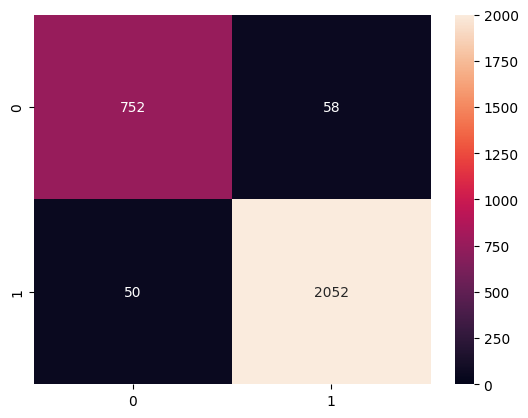

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion,annot=True,fmt='.0f',vmin=0,vmax=2000)
plt.show()

In [ ]:
df.round(3)

,Configuration,Accuracy,0_prec,0_recall,0_f1,1_prec,1_recall,1_f1
0,"{'hidden_size': 64, 'bidirectional': False, 'n...",0.727,0.574,0.067,0.119,0.732,0.981,0.838
1,"{'hidden_size': 64, 'bidirectional': False, 'n...",0.722,0.000,0.000,0.000,0.722,1.000,0.838
2,"{'hidden_size': 64, 'bidirectional': False, 'n...",0.868,0.737,0.819,0.776,0.927,0.888,0.907
3,"{'hidden_size': 64, 'bidirectional': False, 'n...",0.949,0.928,0.885,0.906,0.957,0.973,0.965
4,"{'hidden_size': 64, 'bidirectional': True, 'nu...",0.922,0.834,0.896,0.864,0.959,0.931,0.945
5,"{'hidden_size': 64, 'bidirectional': True, 'nu...",0.805,0.745,0.454,0.564,0.817,0.940,0.874
6,"{'hidden_size': 64, 'bidirectional': True, 'nu...",0.899,0.763,0.922,0.835,0.967,0.890,0.927
7,"{'hidden_size': 64, 'bidirectional': True, 'nu...",0.835,0.799,0.543,0.647,0.843,0.947,0.892
8,"{'hidden_size': 128, 'bidirectional': False, '...",0.761,0.569,0.578,0.574,0.836,0.832,0.834
9,"{'hidden_size': 128, 'bidirectional': False, '...",0.722,0.000,0.000,0.000,0.722,1.000,0.838


In [ ]:
df.to_excel(f"{MODEL}_results.xlsx")

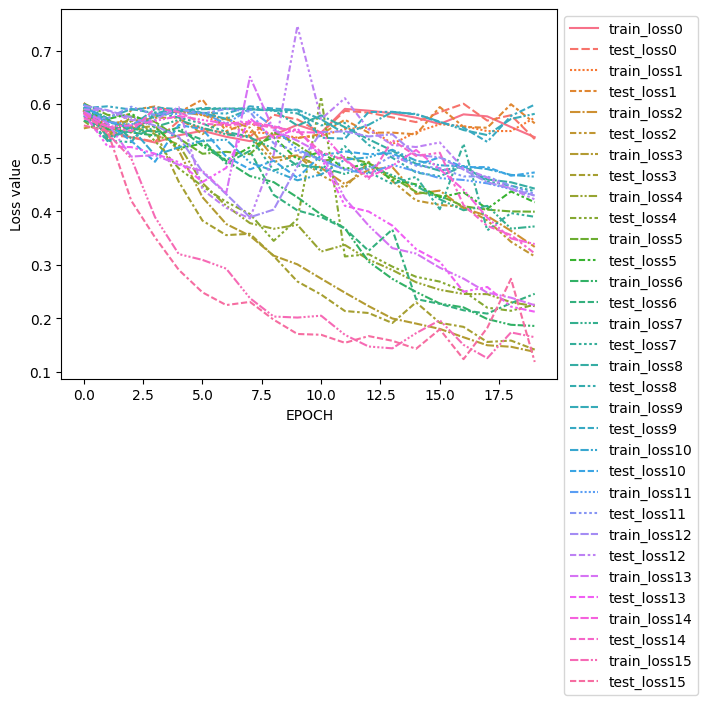

In [ ]:
losses_dict = {}

for idx, elem in enumerate(losses_series):
    losses_dict.update({
        f"train_loss{idx}": elem[0],
        f"test_loss{idx}": elem[1]
    })

losses = pd.DataFrame(losses_dict)

ax = sns.lineplot(losses)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("EPOCH")
plt.ylabel("Loss value")
plt.show()

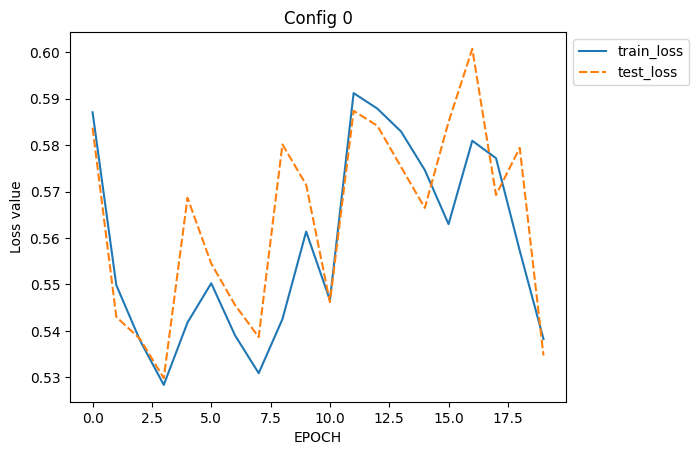

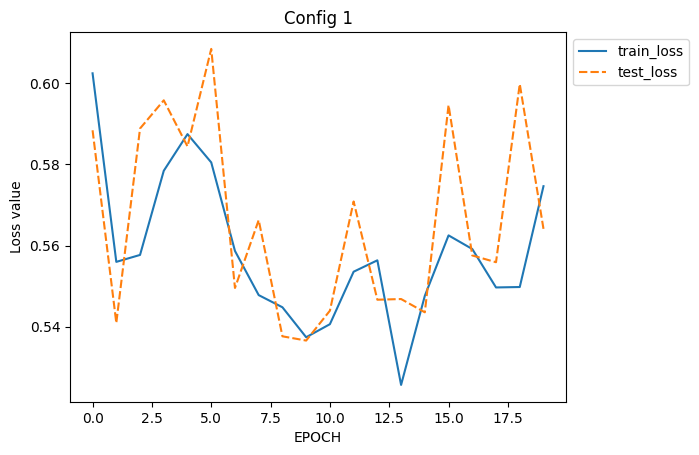

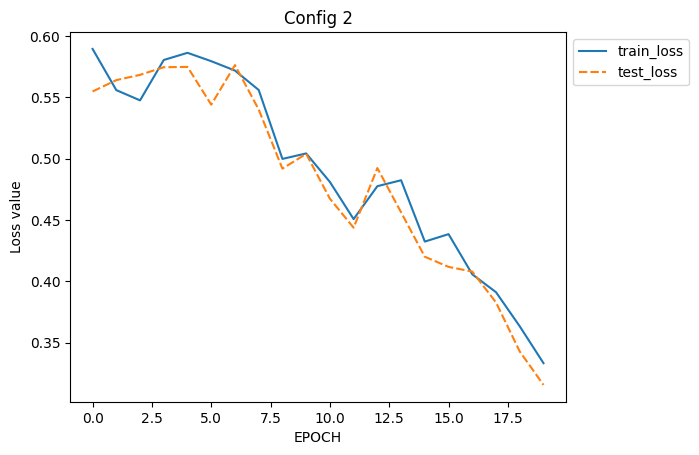

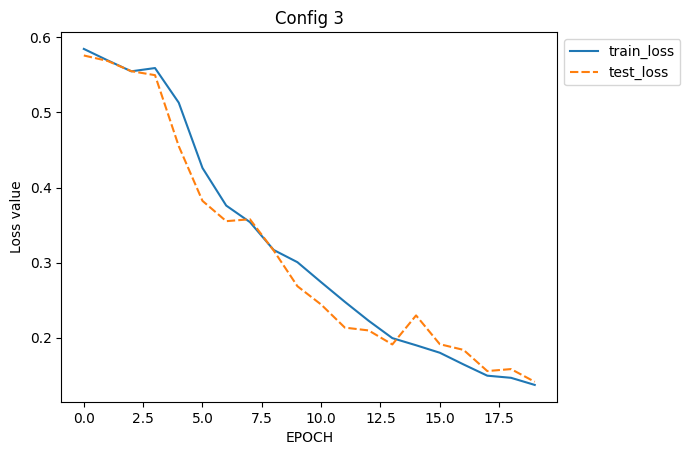

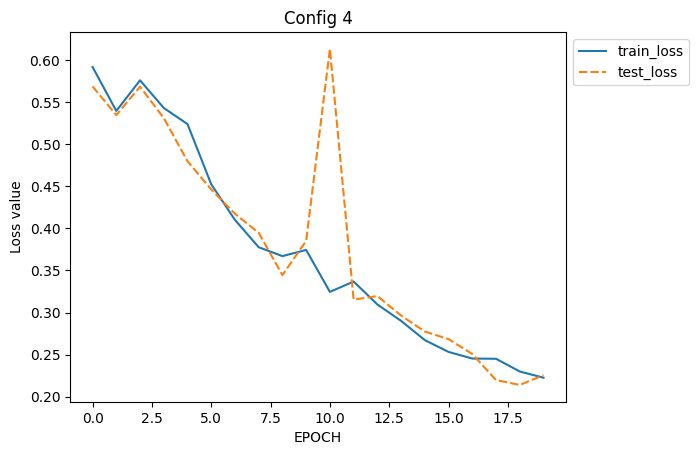

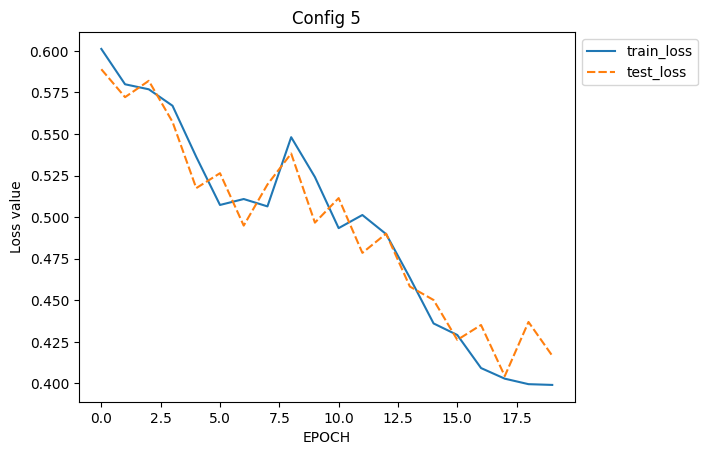

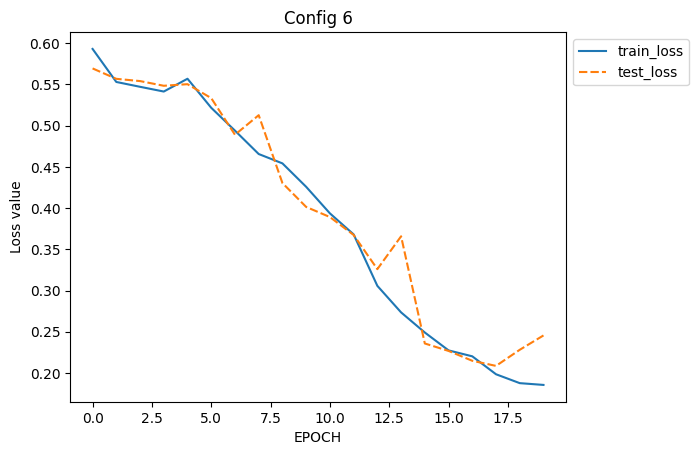

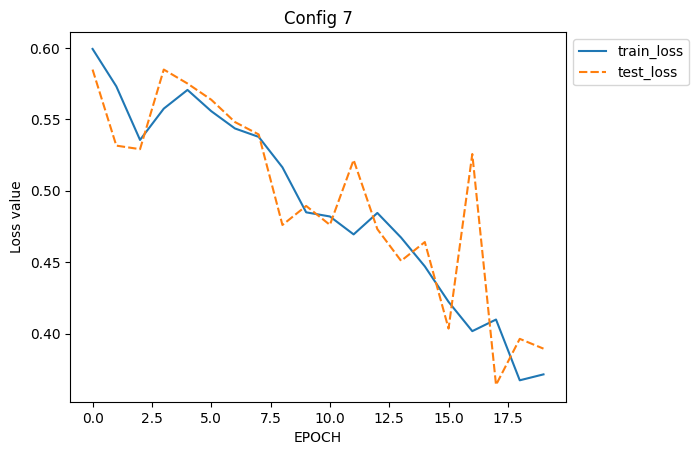

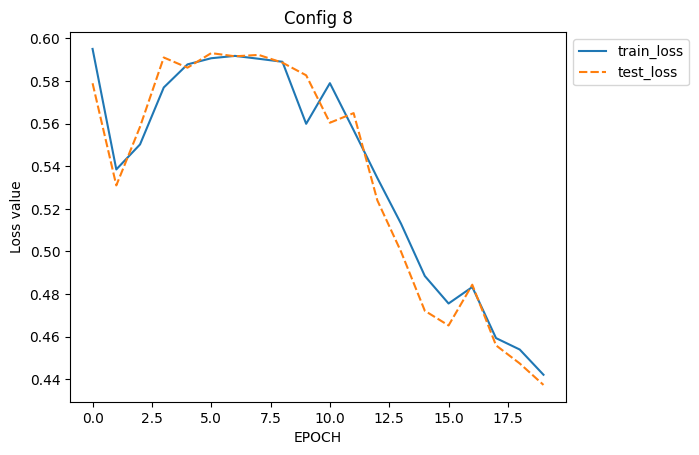

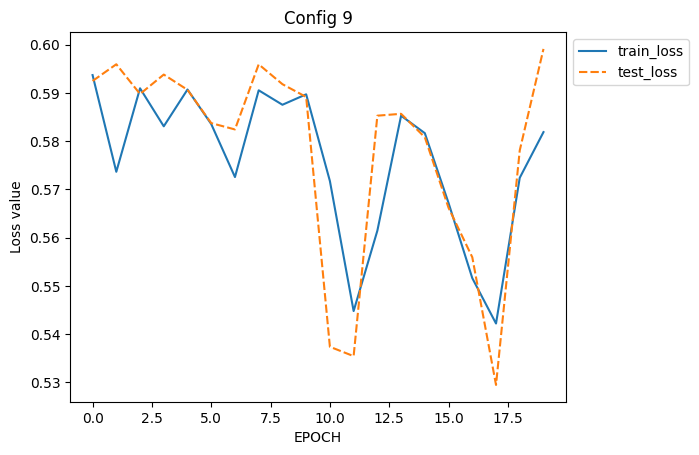

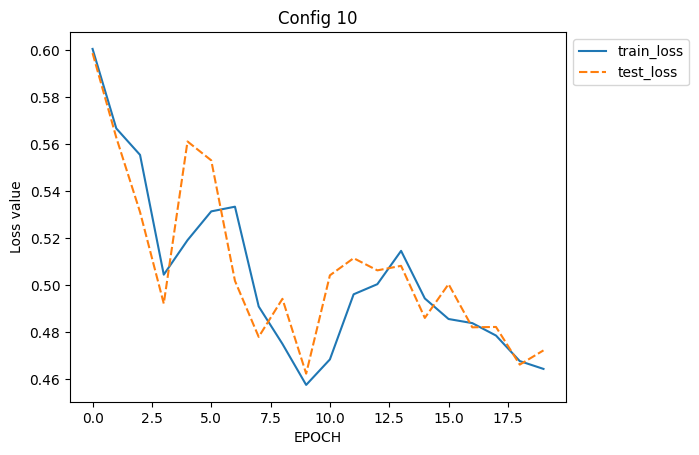

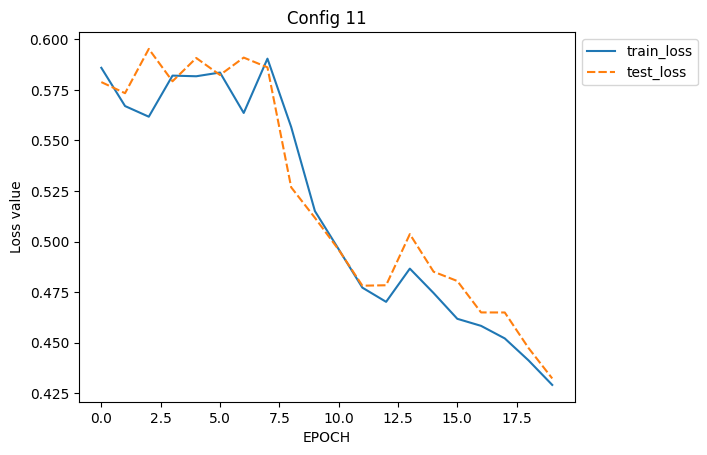

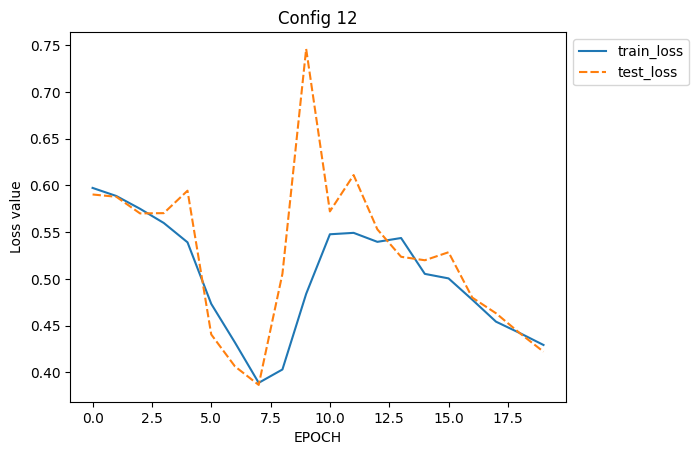

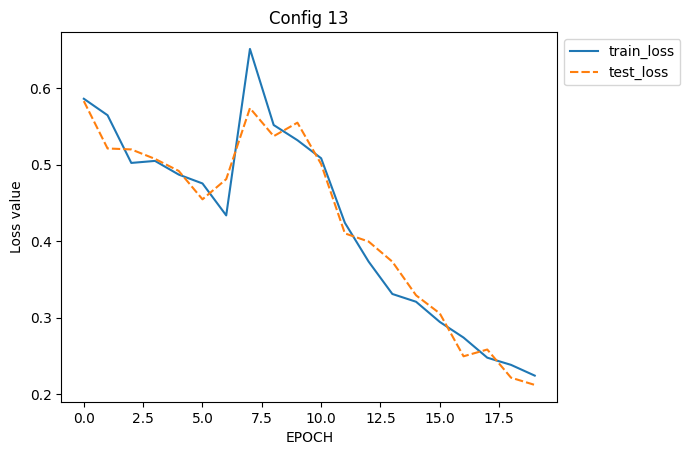

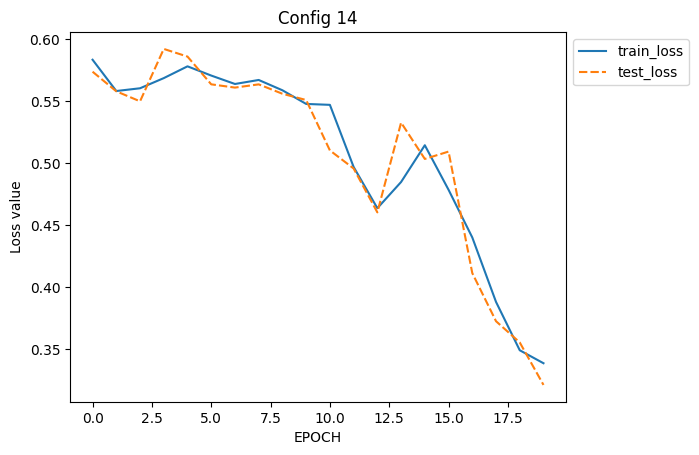

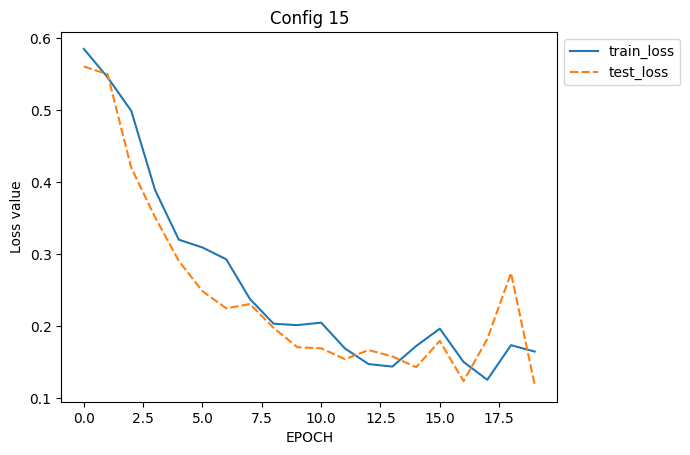

In [ ]:
for idx, elem in enumerate(losses_series):
    d = {"train_loss": elem[0], "test_loss":elem[1]}
    ax = sns.lineplot(d)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xlabel("EPOCH")
    plt.ylabel("Loss value")
    plt.title(f"Config {idx}")
    plt.show()